<a href="https://colab.research.google.com/github/khanel/style_transfer/blob/main/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

this notebook is an implementation of this paper titled ['Image Style Transfer Using Convolutional Neural Network'](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf). However, please note that my implementation will not cover all aspects presented in the paper.

Before delving into the paper, let's first examine the output of the convolutional layers in a trained Convolutional Neural Network (CNN). For this purpose, we will use the pre-trained VGG19 model.
First of all, we'll begin by adding the necessary packages to our project. We'll fetch the VGG19 model with pre-trained weights, which can be easily obtained using the torchvision package in PyTorch.

In [1]:
import torch
import torchvision.models as models

# Load the pre-trained VGG19 model
vgg19 = models.vgg19(pretrained=True)
print(vgg19)
# Set the model to evaluation mode
vgg19.eval()

# for this procedure we only need features
vgg19 = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg19.parameters():
    param.requires_grad_(False)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

We will use Van Gogh's "The Starry Night" painting as an example to observe the output of the first convolutional layer.

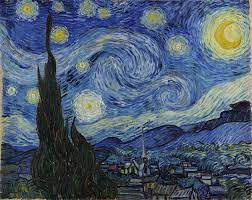

In [2]:
import urllib.request
from PIL import Image, ImageFile
from io import BytesIO
import requests


def load_image(img_path, max_size=400 ):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
        
    
    return image



image_url = "style.jpeg"

image = load_image(image_url)

image.show()


In VGG19, the model is divided into three main parts: features, average pooling, and classifier.

1. Features:
The features part consists of a series of convolutional layers, ReLU activation functions, and max pooling.It consist fo 5 series (seperated by maxpooling).These layers are responsible for learning hierarchical representations of the input image. In VGG19, the first convolutional layer can be accessed using `vgg19.features[0]`. It produces 64 output channels.

2. Average Pooling:
After the features part, the output is passed through average pooling layers. These layers downsample the spatial dimensions of the features while preserving important information.

3. Classifier:
The classifier part of VGG19 consists of fully connected layers that map the extracted features to the final class probabilities. It performs classification based on the learned representations.

In our case, we are particularly interested in the features part, which includes the convolutional layers, ReLU activation functions, and max pooling. We specifically access the first convolutional layer using `vgg19.features[0]`, which produces 64 output channels.

By passing an image through this first convolutional layer, we can observe the response of the network to the input image and visualize the output channels.

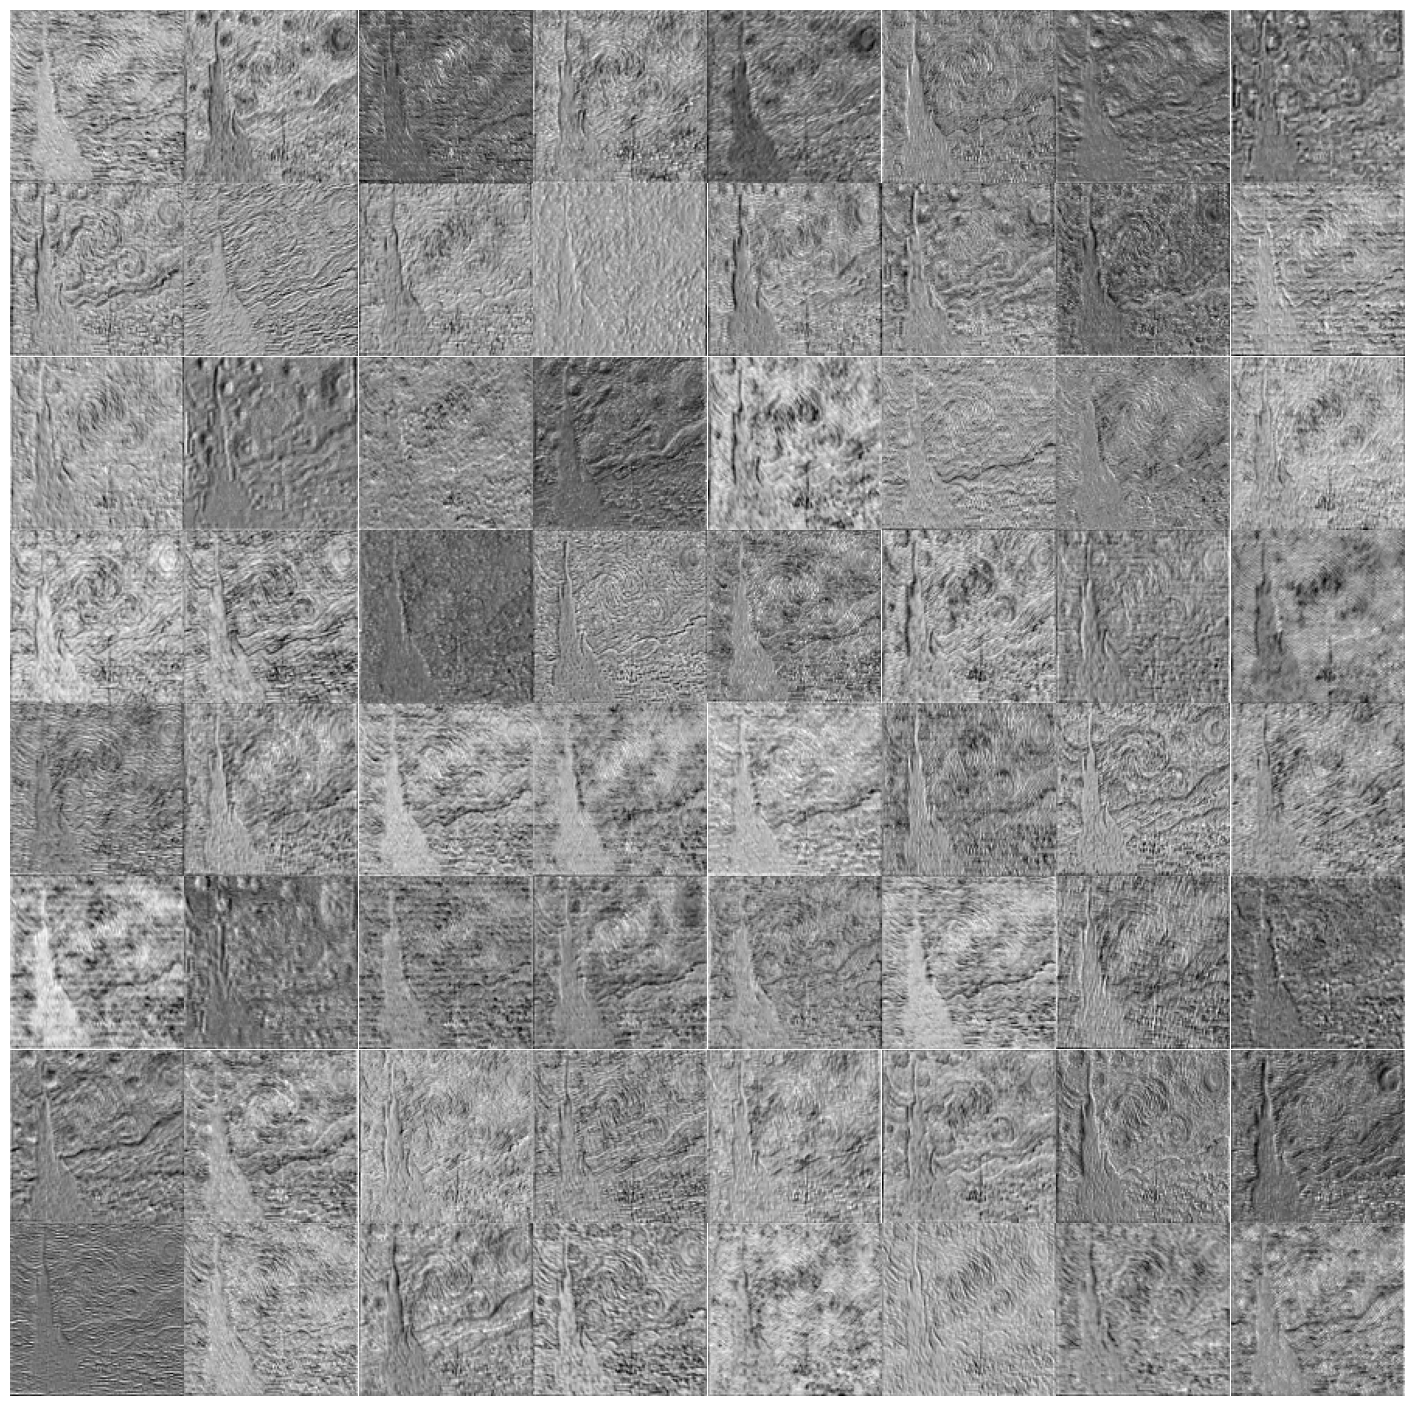

In [15]:
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


def transform(image):
    # Define the image transformation
    transformer = transforms.Compose(
        [
            transforms.Resize((224, 224)),  # Resize the image to the model's input size
            transforms.ToTensor(),  # Convert the image to a tensor
            transforms.Normalize(
                mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
            ),  # Normalize the image
        ]
    )
    return transformer(image)[:3,:,:].unsqueeze(0)


def pass_image_through_model(image, model, layer_index):
    # Load and transform the image
    input_tensor = transform(image)

    # Pass the image through the model until the specified layer index
    output = input_tensor
    for i in range(layer_index + 1):
        output = model[i](output)

    return output.squeeze()


def display_output_tensor(output_tensor):
    # Convert the tensor to a numpy array
    output_array = output_tensor.detach().numpy()

    # Calculate the number of output images and their layout
    num_images = 64
    rows = int(num_images**0.5)
    cols = int(num_images / rows)

    # Create subplots for each output image
    fig, axes = plt.subplots(rows, cols, figsize=(18, 18))

    # Flatten the axes if necessary
    if num_images == 1:
        axes = [axes]

    # Display each output image
    for i, ax in enumerate(axes.flat):
        ax.imshow(output_array[i], cmap="gray")
        ax.axis("off")

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()


def display_specified_tensor_output(tensor, index):
    output_image = tensor[index].detach().numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(output_image, cmap="gray")
    plt.axis("off")
    plt.show()

def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

output_tensor = pass_image_through_model(image=image, model=vgg19, layer_index=5)
display_output_tensor(output_tensor)


let's see one of them with details

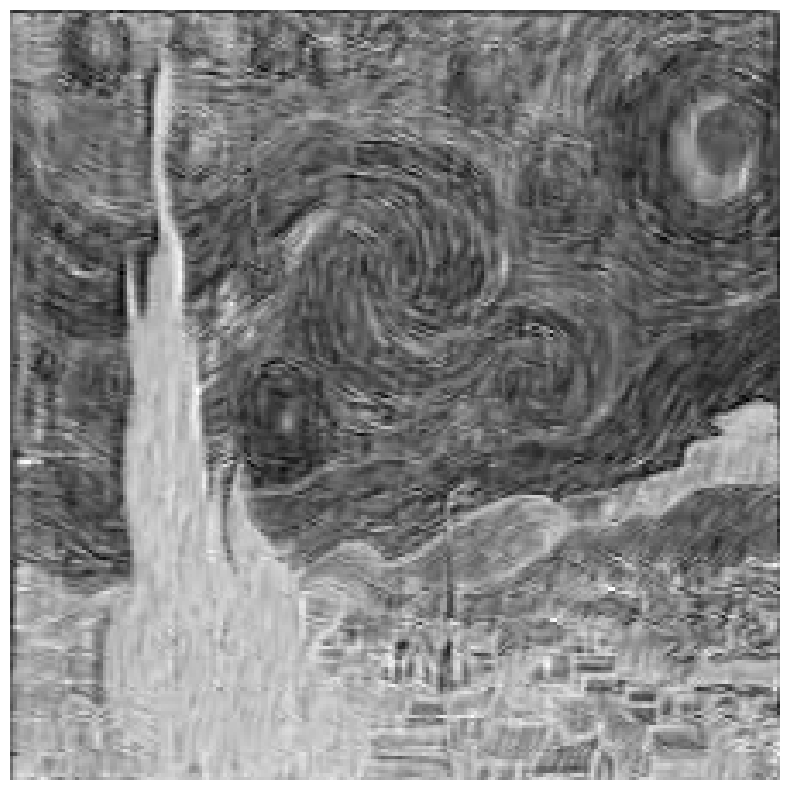

In [4]:
output_tensor = pass_image_through_model(image=image, model=vgg19, layer_index=0)
display_specified_tensor_output(tensor=output_tensor, index=9)

As you can see from the outputs this layer is capable of identifying significant patterns and shapes in the input image.The first convolutional layer in VGG19 performs local receptive field operations, where each neuron is connected to a small region of the input image. By applying various filters, such as edge detectors or texture extractors, the layer can detect specific features in the image.

Convolutional layers in neural networks tend to discard fine details while emphasizing important content in an image. For instance, the tree may lose some details but gain a more distinct shape.

This behavior helps convolutional layers focus on capturing essential features, making them effective in tasks like image recognition. By prioritizing important content over intricate details, the network becomes better at identifying key patterns and shapes in the data.

It is important to note that the VGG19 model used in this example is pretrained on a large dataset, such as ImageNet.

Feel free to further explore and analyze other output channels of the first convolutional layer to deepen your understanding of how convolutional neural networks can capture and represent visual information.


# Now let's get into the paper
In this paper, style transfer uses the features found in the 19-layer VGG Network, which is comprised of a series of convolutional and pooling layers with a ReLU activation function in between, and a few fully-connected layers. In the image below, the convolutional layers are named by stack and their order in the stack. Conv_1_1 is the first convolutional layer that an image is passed through, in the first stack. Conv_2_1 is the first convolutional layer in the *second* stack. The deepest convolutional layer in the network is conv_5_4.

<img src='https://github.com/khanel/style_transfer/blob/main/vgg19_convlayers.png?raw=1' width=80% />

So let's create a dictionary to name the convulotional layers we'll use with this convention

In [5]:
layers = {
    "0": "conv1_1",
    "5": "conv2_1",
    "10": "conv3_1",
    "19": "conv4_1",
    "21": "conv4_2",  ## content representation
    "28": "conv5_1",
}


Now we need a method to get feature in layers and return all of them, we could reuse the above pass_image_through_model we defined but its better to change it a bit and make it more optimized for our case.

In [6]:
def get_features(image, model, layers=None):

    
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

Style is an abstract idea, but we can use Gram matrix to find non-localized features in the image, such as prominent colors and texture, and accept them as the style of this image.
The output of every convolutional layer is a Tensor with dimensions associated with the `batch_size`, a depth, `d` and some height and width (`h`, `w`). The Gram matrix of a convolutional layer can be calculated as follows:
* Get the depth, height, and width of a tensor using `batch_size, d, h, w = tensor.size`
* Reshape that tensor so that the spatial dimensions are flattened
* Calculate the gram matrix by multiplying the reshaped tensor by it's transpose 

 So let’s define the Gram matrix method

In [7]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    b, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(b * d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram

At this point we can extract features and calculate gram matrix of given layer

In [9]:
style = transform(load_image('style.jpeg'))
content = transform(load_image('content.jpeg'))

content_features = get_features(content, vgg19, layers)
style_features = get_features(style, vgg19, layers)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# target image will be a midified version from content image
target = content.clone().requires_grad_(True)

We can define weight for style representaion of each layer. By weighting earlier layers (`conv1_1` and `conv2_1`) more, we get _larger_ style artifacts in the target image and if we weight later layers, we get more emphasis on smaller features. This is because each layer is a different size and together they create a multi-scale style representation!

We can also assign weights to the content and style. The higher the content weight, the more content we will have, and the same applies to style.

In [10]:
# by giving more weights to first layer we will have an image with larger style artifacs
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

## Updating the Target & Calculating Losses
 
In this case, we will not train a model to combine two images together. Instead, we will modify the target image from the given content image to an image with the style of the style image. To do this, we will change the target image into a tensor with required gradients and update its weights until we achieve the desired result.

Now we need to define loss functions, for style, content and a total loss 


#### Content Loss

The content loss will be the mean squared difference between the target and content features at layer `conv4_2`. This can be calculated as follows: 
```python
content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
```

#### Style Loss

The style loss is calculated in a similar way, only we have to iterate through a number of layers, specified by name in our dictionary `style_weights`. 

#### Total Loss

Finally, we'll create the total loss by adding up the style and content losses and weighting them with your specified alpha and beta!

Intermittently, we'll print out this loss; don't be alarmed if the loss is very large. It takes some time for an image's style to change and we should focus on the appearance of target image rather than any loss value. Still, we should see that this loss decreases over some number of iterations

In [11]:
# if gpu will be available everything will send into gpu

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vgg19 = vgg19.to(device)

In [12]:
target.shape

torch.Size([1, 3, 224, 224])

Total loss:  20703.333984375


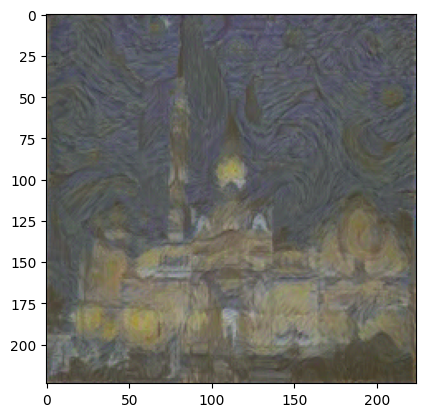

Total loss:  13923.3359375


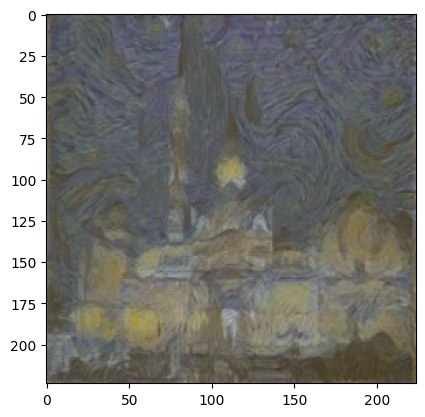

Total loss:  11943.765625


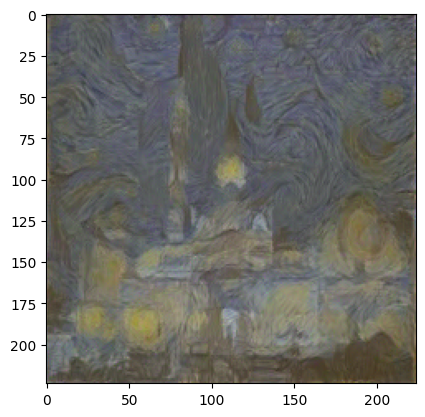

Total loss:  11159.7431640625


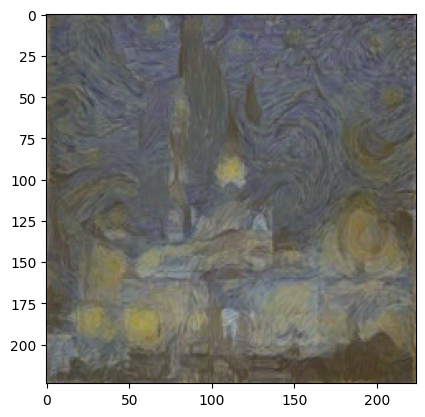

Total loss:  10490.7431640625


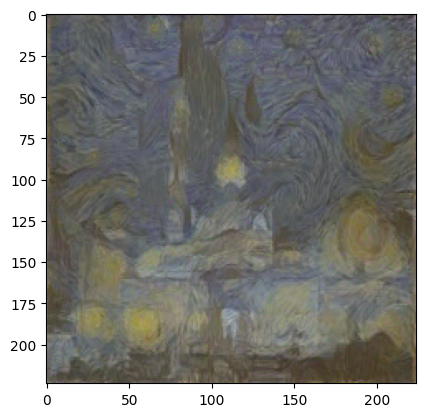

In [17]:
from torch import optim 

# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg19, layers)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()
        

Now we bring starry night to the palace!